Now that we've cleaned the data, it is time to apply ML model.

The idea was to create a Regressor model for every `PRODUCT_ID` separately, such that `PRODUCT_LENGTH` could be correlated to the score we generated from the text, through the `PRODUCT_ID` assigned. It was noted that although many items with similar `PRODUCT_ID`s belonged to same size/category (eg. 4 mostly contained books), it wasn't neccessarily a pattern. But, considering the time constraint, we went ahead with it anyway.

 In the immediate code, we faced some more NaN values, so we cleaned for the last time.
After that, we chose to go with a particular class, to apply the ML model.

In [1]:
import pandas as pd
import numpy as np
clean1 = "/home/user0531/Downloads/ALL_CSVs/csv1.csv"
df = pd.read_csv(clean1)
new_df = df [df['PRODUCT_TYPE_ID'] == 1]
new_df = new_df.dropna()


new_df.head()

,PRODUCT_ID,PRODUCT_TYPE_ID,PRODUCT_LENGTH,TEXT
11,833712,1,433.070,La Mure / Valbonnais gps
12,648364,1,759.841,J'ecris des lettres! premiers exercices d'écri...
22,655356,1,539.369,100 clés des villes sœurs. Eu - Le Tréport - M...
45,699328,1,909.447,Duden Kindergarten Lexikon
51,370796,1,1325.000,Four Seasons 2020 Calendar


In [14]:
new_df.shape

(23962, 4)

Here, we splitted the dataset even before applying the `BERT` Model, which was only used to assign a relative score and not training. In our experience, when we scored the entire dataset and then trained the model, the error score was about ~0.16%. Believing that must be because of early usage with `BERT` model, and fearing that we might be testing on trained data, we splitted the dataset into 80:20 ratio early on.

In [2]:
r,c = new_df.shape
n = int(0.8*r)
n


19169

In [4]:
train_a = new_df.iloc[:n][:]
test_a = new_df.iloc[n+1:][:]

In [13]:
test_a.head()

,PRODUCT_ID,PRODUCT_TYPE_ID,PRODUCT_LENGTH,TEXT
360021,725606,1,492.125000,Ben Suat Derviş
360030,212030,1,600.000000,Rose Journal
360061,579749,1,551.000000,Wildwood
360071,2201967,1,866.141731,THE PSYCHOLOGY OF MONEY: Timeless lessons on w...
360093,622626,1,429.133000,J'ai rencontre des gens formidables


In the next section, we imported `bert-base-uncased` which although more information intensive, is also bulkier and slower to process. Later on it became our reason, why we couldn't achieve a completely deployable model for the challenge. From our experience, DO NOT USE IT IN TIGHT SCHEDULES!. There are plenty alternatives, such as DistilBERT, ALBERT that provide competitive performance.

In [8]:
from transformers import AutoTokenizer, AutoModel
import torch


tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
model = AutoModel.from_pretrained("bert-base-uncased")

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


The next function, for each row, extracts the text from the ‘TEXT’ column of that row using the .iloc method and stores it in a variable called output_text.
The function then encodes this text using a tokenizer and a pre-trained model called model. The encoded input is then passed through the model to obtain an output tensor.
A regression layer is then applied to this tensor using PyTorch’s torch.nn.Linear() function to obtain a single output value. This output value is then averaged across all rows of the DataFrame and appended to the relative_score list.
Finally, the function returns this list of relative scores.
This score becomes the core of our model.

In [14]:
from tqdm import tqdm
def extract_data(df):
    relative_score = []
   
    for i in tqdm(range(len(df))):
        output_text = (df.iloc[i]['TEXT'])
            
        encoded_input = tokenizer(output_text, return_tensors='pt',truncation = True)
        output = model(**encoded_input)

        regression_layer = torch.nn.Linear(768, 1)
        output = regression_layer(output.last_hidden_state)
        #print(type(output)) == torch.Tensor()
        output = torch.mean(output).item()
        relative_score.append(output)

    return relative_score
        

In [10]:

out = extract_data(train_a)
#print(type(out), out)

100%|█████████████████████████████████████| 19169/19169 [08:30<00:00, 37.54it/s]


In [15]:
test_a_out = extract_data(test_a)

100%|███████████████████████████████████████| 4792/4792 [02:13<00:00, 35.93it/s]


In [17]:
train_a['rel_score'] = out

In [7]:
train_a.head(10)

,PRODUCT_ID,PRODUCT_TYPE_ID,PRODUCT_LENGTH,TEXT,rel_score
11,833712,1,433.070,La Mure / Valbonnais gps,0.062352
12,648364,1,759.841,J'ecris des lettres! premiers exercices d'écri...,0.289387
22,655356,1,539.369,100 clés des villes sœurs. Eu - Le Tréport - M...,-0.213257
45,699328,1,909.447,Duden Kindergarten Lexikon,-0.117380
51,370796,1,1325.000,Four Seasons 2020 Calendar,-0.317353
58,518364,1,744.000,I Love Sloths More Than You: Blank Lined Journ...,0.188654
77,679453,1,696.849,"Selbstorganisation, 2.A.",-0.016820
80,365587,1,425.000,Stella Rising (Orca Soundings),0.031334
100,402457,1,500.000,Tales of Cydonia: Volume Two: Cydonia Labyrint...,-0.099079
123,1005026,1,750.000,Dryden; stanzas on the death of Oliver Cromwel...,0.048394


In [18]:
df3 = train_a[['PRODUCT_LENGTH','rel_score']].copy()

In [9]:
df3.head(10)

,PRODUCT_LENGTH,rel_score
11,433.070,0.062352
12,759.841,0.289387
22,539.369,-0.213257
45,909.447,-0.117380
51,1325.000,-0.317353
58,744.000,0.188654
77,696.849,-0.016820
80,425.000,0.031334
100,500.000,-0.099079
123,750.000,0.048394


In [19]:
import matplotlib.pyplot as plt

### In the next section, we plotted a scatter plot of `PRODUCT_LENGTH` and its`rel_score` generated using `BERT` Model. And as our assumption, a certain class was able to generate separate scatter plots, which would aid in prediction.

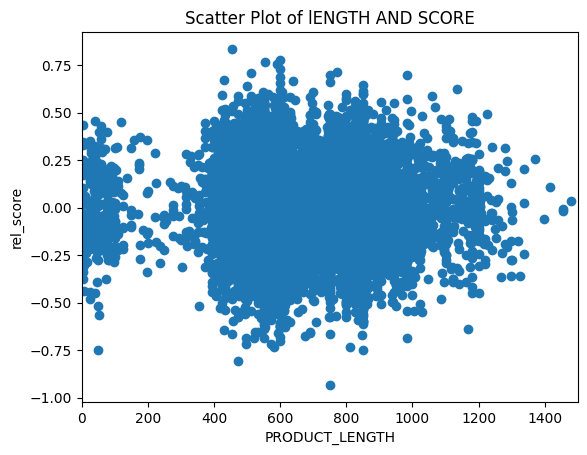

In [20]:
plt.scatter(df3['PRODUCT_LENGTH'], df3['rel_score'])
plt.xlabel('PRODUCT_LENGTH')
plt.ylabel('rel_score')

plt.title('Scatter Plot of lENGTH AND SCORE')
plt.xlim(0,1500)
#plt.ylim(-0.4,0.4)
plt.show()




Here we applied Logistic Regression, to start our data analysis; as seen from the graph it wasn't nearly as fruitful to begin with.

<AxesSubplot:xlabel='PRODUCT_LENGTH', ylabel='rel_score'>

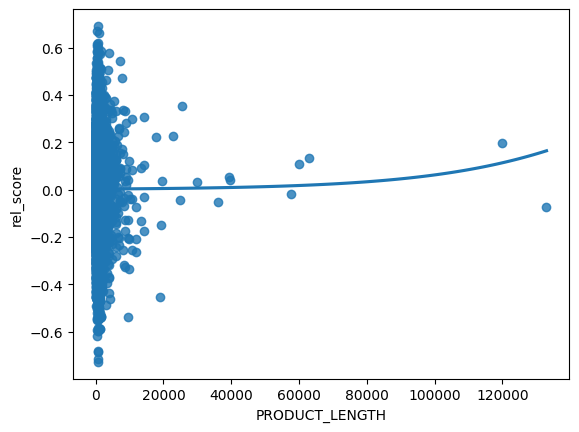

In [36]:

#define the predictor variable and the response variable
x = df3['PRODUCT_LENGTH']
y = df3['rel_score']

#plot logistic regression curve
sns.regplot(x=x, y=y, data=df3, logistic=True, ci=None)

### Here we have skipped over certain parts

In our data Anaysis, we tested algorithms, such as XGBoost, LGBMClassifier and DecisionTrees apart from GradientBoosting, albeit in separate notebooks not covered in this repository.

In our experience, only XGBoost could match the performance by GradientBoosting, but was also slower to train. So naturally, we pivoted towards GradientBoosting.

In [21]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor

# Split the data into training, testing and validation sets
train_df, test_df = train_test_split(df3, test_size=0.2)
test_df, val_df = train_test_split(test_df, test_size=0.5)

# Train the model
X_train = train_df.iloc[:, 1:]
y_train = train_df.iloc[:, 0]
model1 = GradientBoostingRegressor()
model1.fit(X_train, y_train)

# X_train.head(10)
# y_train.head(10)


GradientBoostingRegressor()

In [22]:
# Test the model
X_test = test_df.iloc[:, 1:]
y_test = test_df.iloc[:, 0]
y_pred_test = model1.predict(X_test)

#X_test.head(10)

In [23]:
# Validate the model
X_val = val_df.iloc[:, 1:]
y_val = val_df.iloc[:, 0]
y_pred_val = model1.predict(X_val)

# print("Accuracy on test set: ", model.score(X_test, y_test))
# print("Accuracy on validation set: ", model.score(X_val, y_val))

### BrainTeaser
When we were using entire dataset, the value of `mape_test` was around 0.0164 and `mape_val` was around 0.009. This meant the error for our prediction was 1.64% and 0.9% respectively!! But after splitting the dataset early on, the score for `train_a`, which was now our entire dataset for training, value of `mape_test` and `mape_val` came around 0.68 and 0.67 respectively. Why so?

In [24]:
from sklearn.metrics import mean_absolute_percentage_error

# Calculate mean absolute percentage error on test set
mape_test = mean_absolute_percentage_error(y_test, y_pred_test)
print("Mean Absolute Percentage Error on test set: ", mape_test)

# Calculate mean absolute percentage error on validation set
mape_val = mean_absolute_percentage_error(y_val, y_pred_val)
print("Mean Absolute Percentage Error on validation set: ", mape_val)

Mean Absolute Percentage Error on test set:  0.680788589730321
Mean Absolute Percentage Error on validation set:  0.6699551047574018


In [28]:
test_a['rel_score'] = test_a_out
test_a.head(10)
df4 = test_a[['PRODUCT_LENGTH','rel_score']].copy()
X_ = df4.iloc[:, 1:]
y_ = df4.iloc[:, 0]

In [29]:
X_.head()

,rel_score
360021,-0.012040
360030,0.195990
360061,-0.185342
360071,0.213307
360093,0.170239


In [30]:
test_a_pred = model1.predict(X_)



In [31]:
# Calculate mean absolute percentage error on test set
mape_test = mean_absolute_percentage_error(y_, test_a_pred)
print("Mean Absolute Percentage Error on test set: ", mape_test)

Mean Absolute Percentage Error on test set:  0.5324859820179082


In [3]:
print("Success Score:"100*(1-mape_test))

46.75140179820918


After this, we proceeded to make this model for every `PRODUCT_ID`. THe entire dataset contained around 12,000 `PRODUCT_ID`s. As we got to learn later, this approach, although yielding promising results, was painstakingly slow, prompting us to shift things up to speed up our model, such as using TinyBERT as mentioned above.  

If you've come this far,thanks again for reading. Do leave your suggestions about what we could've done better.
Have a good day!